In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
import swifter
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
#pip install swifter
#nltk.download('vader_lexicon')
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [4]:
df=pd.read_excel('hotel_reviews (2).xlsx')

In [5]:
df.drop(['@'],inplace=True,axis=1)

In [6]:
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [8]:
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [9]:
df['len']=df['Review'].apply(len)

<Axes: >

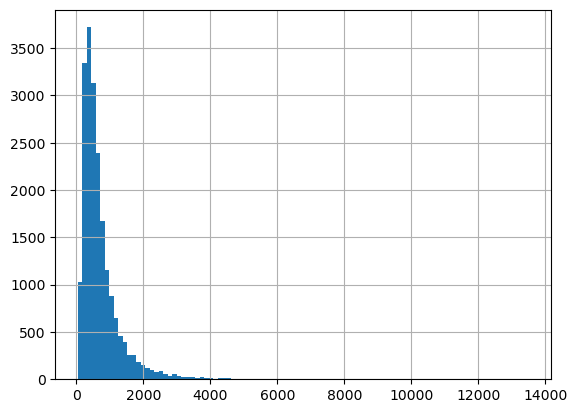

In [10]:
df['len'].hist(bins=100)

In [11]:
mx=df['len'].max()
print('Maximum Length of the Review:',mx)

Maximum Length of the Review: 13501


In [12]:
mn=df['len'].min()
print('Minimum Length of the Review:',mn)

Minimum Length of the Review: 44


In [13]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

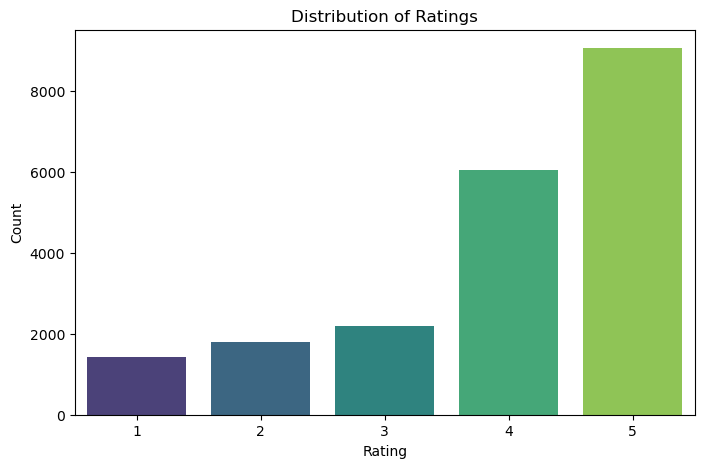

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

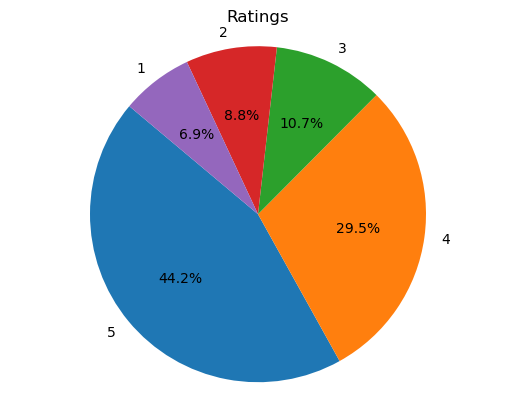

In [15]:
plt.pie(df['Rating'].value_counts(),labels=df['Rating'].value_counts().index,autopct='%1.1f%%',startangle=140)
plt.title('Ratings')
plt.axis('equal')
plt.show()

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

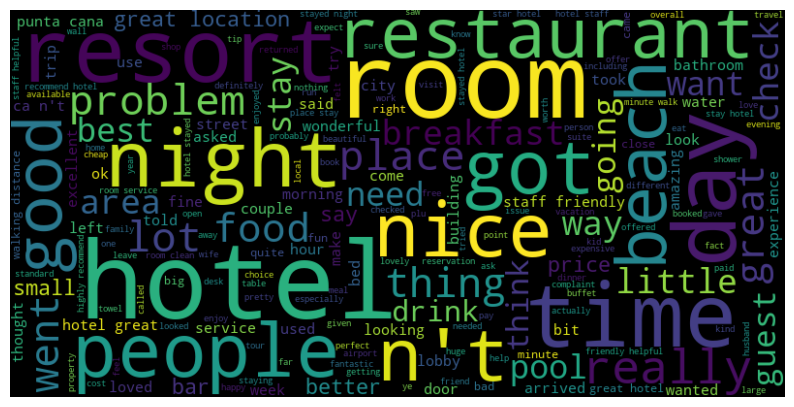

In [17]:
text = ' '.join(df['Review'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400,max_font_size=110,random_state=21).generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis labels
plt.show()

In [18]:
def text_cleaning(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and extra whitespaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove punctuation
    text = ''.join([x for x in text if x not in string.punctuation])

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(['room', 'hotel','restaurant','pepole','day','night'])
    tokens = [x for x in tokens if x not in stop_words]
   #tokens = [x for x in tokens if x not in stopwords.words('english')]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Join the tokens back into a single string
    cleaned_text = ' '.join(tokens)

    return cleaned_text


In [19]:
df['cleaned_text']=df["Review"].swifter.apply(text_cleaning)

Pandas Apply:   0%|          | 0/20491 [00:00<?, ?it/s]

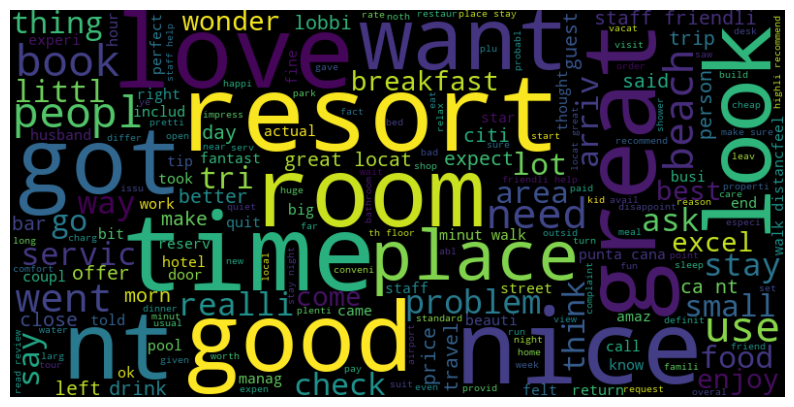

In [20]:
text = ' '.join(df['cleaned_text'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400,max_font_size=110,random_state=21).generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis labels
plt.show()

In [21]:
import requests

url = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/positive-words.txt"
response = requests.get(url)
positive_words = set(response.text.split('\n'))

# Function to extract positive words from a cleaned review
def extract_positive_words(cleaned_text):
    return [word for word in cleaned_text.split() if word in positive_words]

# Apply the function to the 'Cleaned_Review' column
df['Positive_Words'] = df['cleaned_text'].apply(extract_positive_words)

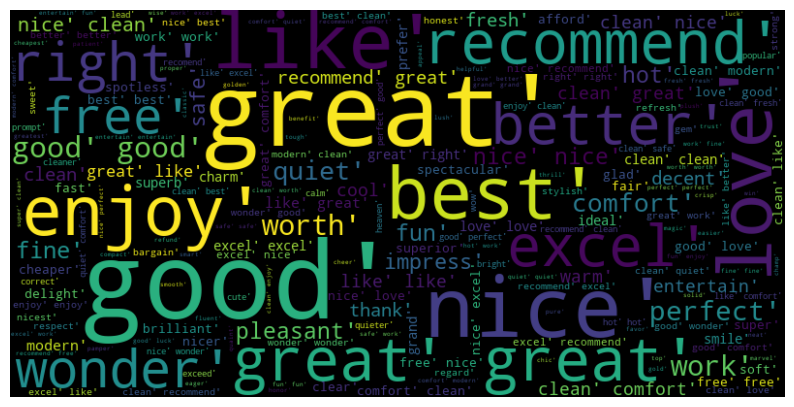

In [22]:
text = ' '.join(df['Positive_Words'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400,max_font_size=110,random_state=21).generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis labels
plt.show()

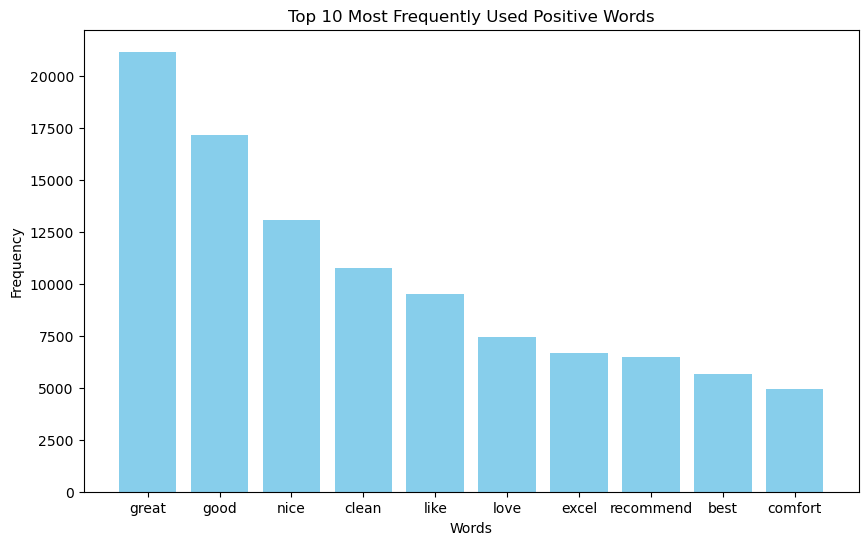

In [23]:
from collections import Counter

# Flatten the list of positive words
all_positive_words = [word for words_list in df['Positive_Words'] for word in words_list]

# Count occurrences of each positive word
word_counts = Counter(all_positive_words)

# Select the top 5 most frequent positive words
top_positive_words = word_counts.most_common(10)

# Separate words and counts for plotting
words, counts = zip(*top_positive_words)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 10 Most Frequently Used Positive Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Download the list of negative words
url_negative = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/negative-words.txt"
response_negative = requests.get(url_negative)
negative_words = set(response_negative.text.split('\n'))

# Function to extract negative words from a cleaned review
def extract_negative_words(cleaned_text):
    return [word for word in cleaned_text.split() if word in negative_words]

# Apply the function to the 'Cleaned_Review' column
df['Negative_Words'] = df['cleaned_text'].apply(extract_negative_words)

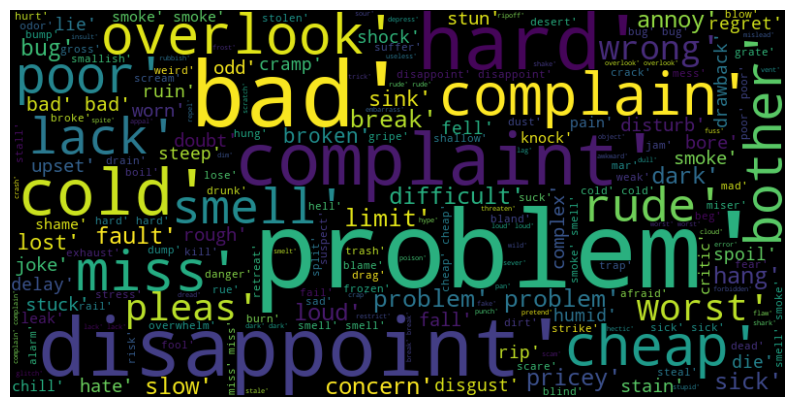

In [25]:
text = ' '.join(df['Negative_Words'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400,max_font_size=110,random_state=21).generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis labels
plt.show()

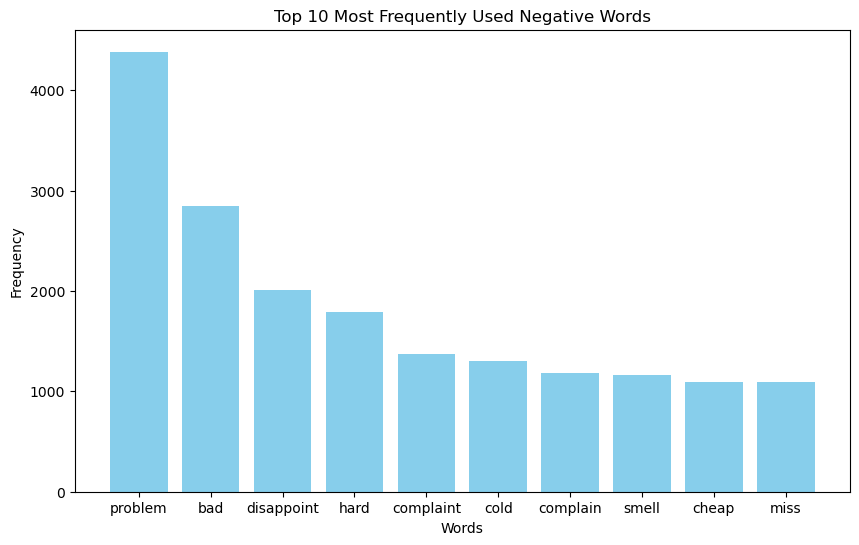

In [26]:
# Flatten the list of positive words
all_negative_words = [word for words_list in df['Negative_Words'] for word in words_list]

# Count occurrences of each positive word
word_counts = Counter(all_negative_words)

# Select the top 5 most frequent positive words
top_negative_words = word_counts.most_common(10)

# Separate words and counts for plotting
words, counts = zip(*top_negative_words)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 10 Most Frequently Used Negative Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [27]:
# Function to extract words not in positive or negative words
def extract_non_sentiment_words(cleaned_text):
    return [word for word in cleaned_text.split() if word not in positive_words and word not in negative_words]

# Apply the function to the 'Cleaned_Text' column
df['Non_Sentiment_Words'] = df['cleaned_text'].apply(extract_non_sentiment_words)


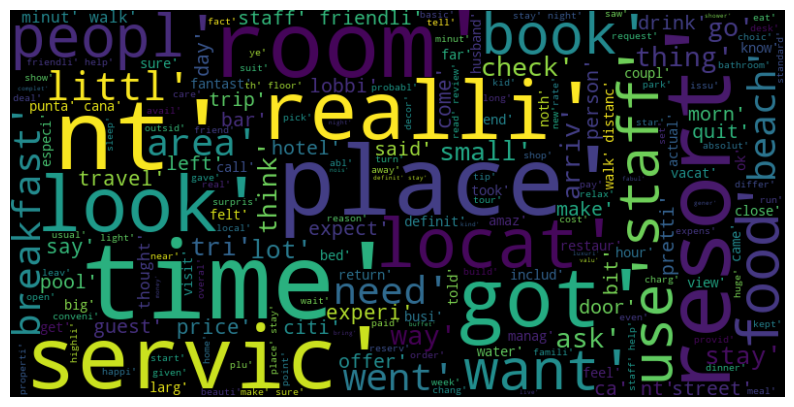

In [28]:
text = ' '.join(df['Non_Sentiment_Words'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400,max_font_size=110,random_state=21).generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis labels
plt.show()

In [29]:
# Define a list of amenity words
amenity_words = ['pool', 'gym', 'wifi', 'park', 'pet','refriger', 'kitchen', 'coffe', 'toilet', 'tissu', 'breakfast', 'pillow', 'spa', 'fridg', 'cook', 'game', 'music', 'beach', 'shuttl', 'bar', 'food', 'tast', 'air', 'water', 'bed']

# Function to check for amenity words in cleaned text
def check_amenities(cleaned_text):
    return [amenity for amenity in amenity_words if amenity in cleaned_text.lower()]

# Apply the function to the 'Cleaned_Text' column
df['Amenities'] = df['cleaned_text'].apply(check_amenities)

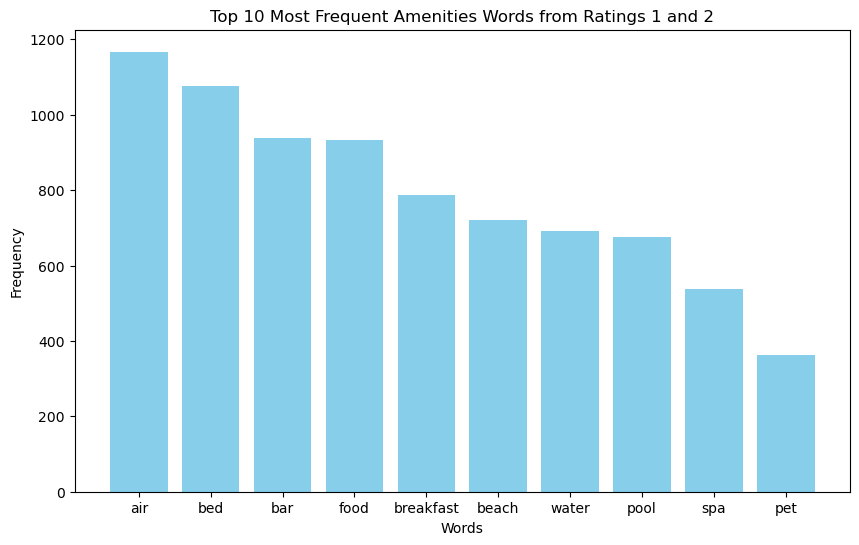

In [30]:
# Flatten the list 
all_words_combined = [word for words_list in df[(df['Rating'] == 1) | (df['Rating'] == 2)]['Amenities'] for word in words_list]

# Count occurrences of each word for combined ratings
word_counts_combined = Counter(all_words_combined)

# Select the top 10 most frequent words for combined ratings
top_words_combined = word_counts_combined.most_common(10)

# Separate words and counts for plotting
words_combined, counts_combined = zip(*top_words_combined)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(words_combined, counts_combined, color='skyblue')
plt.title('Top 10 Most Frequent Amenities Words from Ratings 1 and 2')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

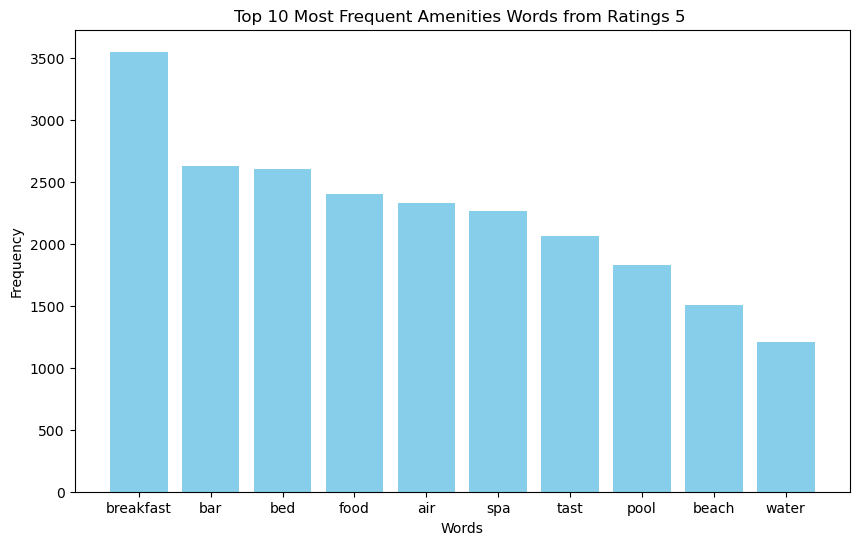

In [31]:
# Flatten the list 
all_words_combined = [word for words_list in df[df['Rating'] == 5]['Amenities'] for word in words_list]

# Count occurrences of each word for combined ratings
word_counts_combined = Counter(all_words_combined)

# Select the top 10 most frequent words for combined ratings
top_words_combined = word_counts_combined.most_common(10)

# Separate words and counts for plotting
words_combined, counts_combined = zip(*top_words_combined)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(words_combined, counts_combined, color='skyblue')
plt.title('Top 10 Most Frequent Amenities Words from Ratings 5 ')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [32]:
# # Download the VADER lexicon for sentiment analysis

# def analyze_sentiment(text):
#     # Initialize the Sentiment Intensity Analyzer
#     sia = SentimentIntensityAnalyzer()
    
#     # Get the sentiment scores for the given text
#     sentiment_scores = sia.polarity_scores(text)
    
#     # Determine the sentiment based on the compound score
#     if sentiment_scores['compound'] <=-0.7:
#         sentiment = '1'
#     elif sentiment_scores['compound'] <= -0.3 and sentiment_scores['compound'] >=-0.6:
#         sentiment = '2'
#     elif sentiment_scores['compound'] <= 0.2 and sentiment_scores['compound'] >=-0.2:
#         sentiment = '3'
#     elif sentiment_scores['compound'] <= 0.6 and sentiment_scores['compound'] >=0.3:
#         sentiment = '4'
#     else:
#         sentiment = '5'
    
#     return sentiment


In [31]:
# df['SA_ratings'] = df['cleaned_text'].apply(analyze_sentiment)

In [32]:
# plt.pie(df['Rating'].value_counts(),labels=df['SA_ratings'].value_counts().index,autopct='%1.1f%%',startangle=140)
# plt.title('Ratings by Sentiment Analysis')
# plt.axis('equal')
# plt.show()

In [33]:
# # Create a figure with two subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Plot the first pie chart (Ratings by Sentiment Analysis)
# ax1.pie(df['Rating'].value_counts(), labels=df['SA_ratings'].value_counts().index, autopct='%1.1f%%', startangle=140)
# ax1.set_title('Ratings by Sentiment Analysis')
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# # Plot the second pie chart (Ratings)
# ax2.pie(df['Rating'].value_counts(), labels=df['Rating'].value_counts().index, autopct='%1.1f%%', startangle=140)
# ax2.set_title('Ratings')
# ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# # Adjust layout for better spacing
# plt.tight_layout()
# plt.show()

In [34]:
# Define a list of amenity words
roorm_realated_words =['clean', 'spaciou', 'comfort', 'cozi', 'stylish', 'design', 'furnish', 'modern', 'luxuri', 'maintain', 'tidi', 'neat', 'beauti', 'quiet', 'peac', 'relax', 'appoint', 'equip', 'amen', 'bed', 'comfort', 'view', 'light', 'heat', 'size', 'layout', 'furnitur', 'decor', 'wifi']

# Function to check for amenity words in cleaned text
def check_amenities(cleaned_text):
    return [amenity for amenity in roorm_realated_words if amenity in cleaned_text.lower()]

# Apply the function to the 'Cleaned_Text' column
df['roorm_realated_words'] = df['cleaned_text'].apply(check_amenities)

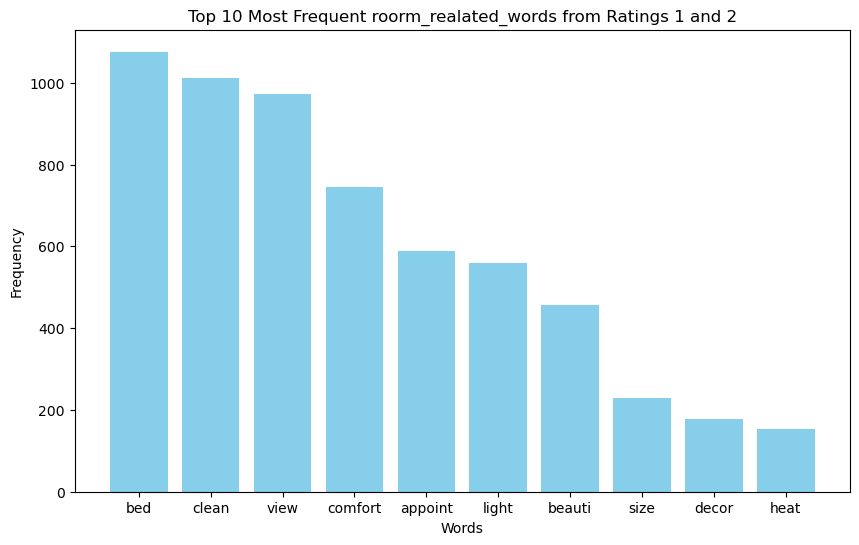

In [35]:
# Flatten the list 
all_words_combined = [word for words_list in df[(df['Rating'] == 1) | (df['Rating'] == 2)]['roorm_realated_words'] for word in words_list]

# Count occurrences of each word for combined ratings
word_counts_combined = Counter(all_words_combined)

# Select the top 10 most frequent words for combined ratings
top_words_combined = word_counts_combined.most_common(10)

# Separate words and counts for plotting
words_combined, counts_combined = zip(*top_words_combined)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(words_combined, counts_combined, color='skyblue')
plt.title('Top 10 Most Frequent roorm_realated_words from Ratings 1 and 2')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

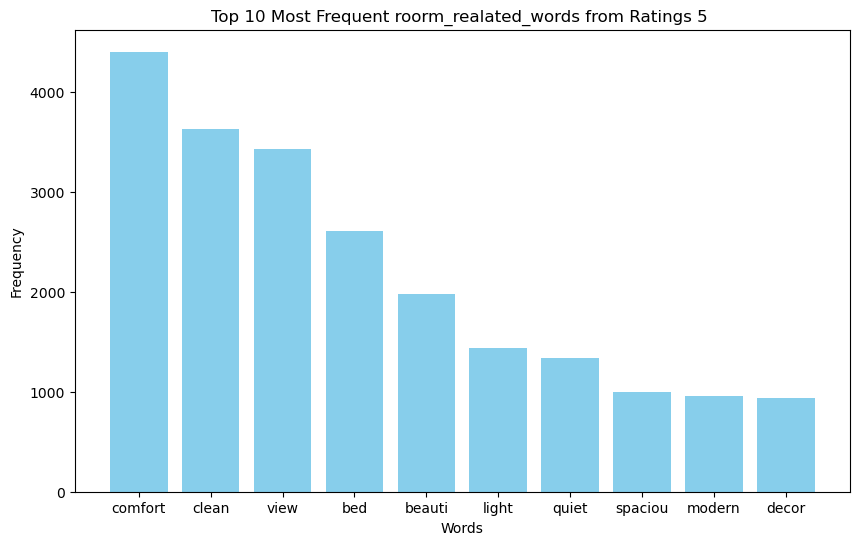

In [36]:
# Flatten the list 
all_words_combined = [word for words_list in df[df['Rating'] == 5]['roorm_realated_words'] for word in words_list]

# Count occurrences of each word for combined ratings
word_counts_combined = Counter(all_words_combined)

# Select the top 10 most frequent words for combined ratings
top_words_combined = word_counts_combined.most_common(10)

# Separate words and counts for plotting
words_combined, counts_combined = zip(*top_words_combined)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(words_combined, counts_combined, color='skyblue')
plt.title('Top 10 Most Frequent roorm_realated_words from Ratings 5 ')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [33]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression

In [38]:
# def vector(clean_text):
#     count=CountVectorizer(ngram_range=(1,1),analyzer='word')
#     c=count.fit_transform([clean_text])
#     tfidf=TfidfTransformer()
#     t=tfidf.fit_transform(c)
#     return t

# df['vector']=df['cleaned_text'].apply(vector)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Review                20491 non-null  object
 1   Rating                20491 non-null  int64 
 2   len                   20491 non-null  int64 
 3   cleaned_text          20491 non-null  object
 4   Positive_Words        20491 non-null  object
 5   Negative_Words        20491 non-null  object
 6   Non_Sentiment_Words   20491 non-null  object
 7   Amenities             20491 non-null  object
 8   roorm_realated_words  20491 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


In [34]:
features=df['cleaned_text']
features

0        nice expens park got good deal stay anniversar...
1        ok noth special charg diamond member hilton de...
2        nice room experi monaco seattl good nt levelpo...
3        uniqu great stay wonder time monaco locat exce...
4        great stay great stay went seahawk game awesom...
                               ...                        
20486    best kept secret rd time stay charm star ca nt...
20487    great locat price view great quick place sight...
20488    ok look nice modern outsid desk staff nt parti...
20489    theft ruin vacat open sept guest week happi st...
20490    peopl talk ca nt believ excel rate nt ye patri...
Name: cleaned_text, Length: 20491, dtype: object

In [35]:
target=df['Rating']
target

0        4
1        2
2        3
3        5
4        5
        ..
20486    5
20487    4
20488    2
20489    1
20490    2
Name: Rating, Length: 20491, dtype: int64

In [36]:
count=CountVectorizer(ngram_range=(1,1),analyzer='word')
c=count.fit_transform(features)
tfidf=TfidfTransformer()
new_features=tfidf.fit_transform(c)

In [37]:
x_train,x_test,y_train,y_test=train_test_split(new_features,target,train_size=0.7,random_state=70)

In [44]:
from sklearn.tree import DecisionTreeClassifier

In [45]:
dec_tree=DecisionTreeClassifier(criterion="entropy",splitter='random',max_depth=5)

In [46]:
params= {'criterion':['gini','entropy'], 'splitter':['best','random'],'max_depth':[1,2,5,7,8,10,12,15]}

In [47]:
grid=GridSearchCV(dec_tree,params)

In [48]:
grid.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                              splitter='random'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 5, 7, 8, 10, 12, 15],
                         'splitter': ['best', 'random']})

In [49]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 12, 'splitter': 'random'}

In [50]:
dec_tree=DecisionTreeClassifier(criterion="gini",splitter='random',max_depth=10)

In [51]:
dec_tree.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=10, splitter='random')

In [52]:
pred=dec_tree.predict(x_test)

In [53]:
accuracy_score(y_test,pred)

0.50113858165257

In [38]:
from sklearn.svm import SVC

In [39]:
svm=SVC(C=1.0,kernel='rbf')

In [40]:
params={'C':[1.0],'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

In [41]:
grid=GridSearchCV(svm,params,n_jobs=-1)

In [42]:
grid.fit(x_train,y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.0],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [43]:
grid.best_params_

{'C': 1.0, 'kernel': 'linear'}